
--- Data Visualization ---


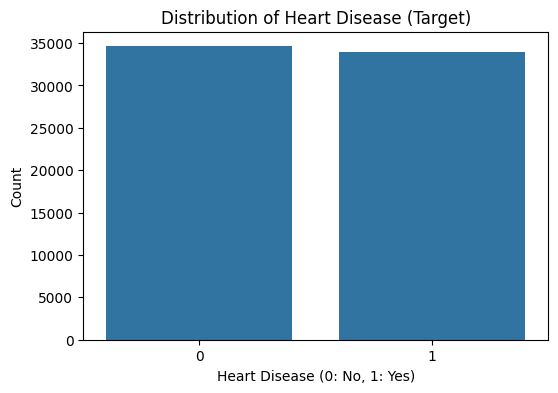

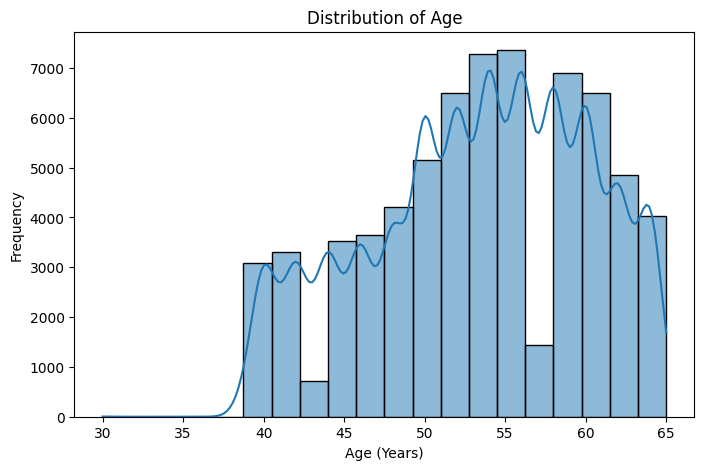

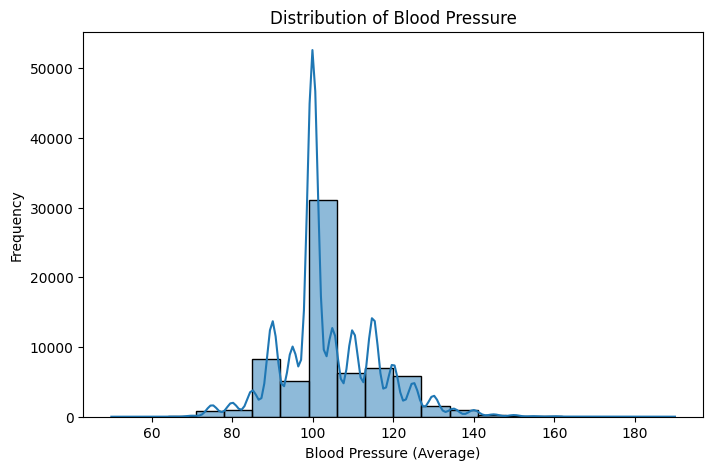

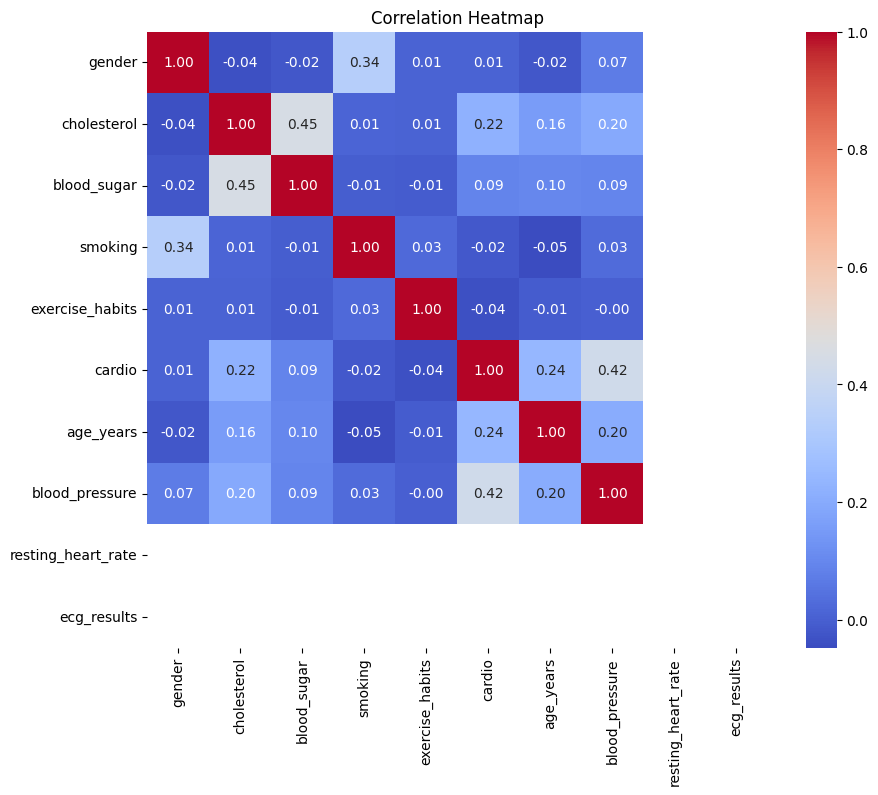

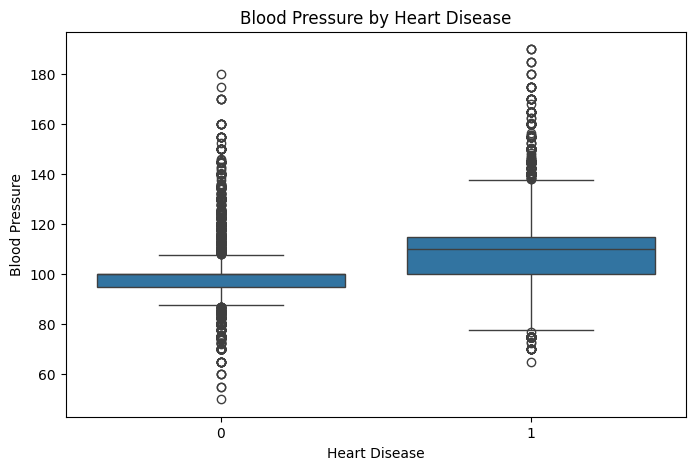


Model Accuracy: 72.91% on test dataset (80% of data)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     27684
           1       0.75      0.68      0.71     27111

    accuracy                           0.73     54795
   macro avg       0.73      0.73      0.73     54795
weighted avg       0.73      0.73      0.73     54795



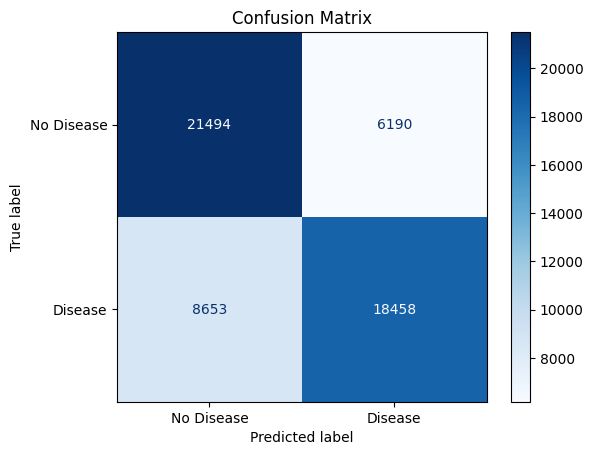


Feature Importance:
              feature  importance
2      blood_pressure    0.617575
0           age_years    0.206973
3         cholesterol    0.100811
5         blood_sugar    0.027813
8     exercise_habits    0.017404
1              gender    0.015751
7             smoking    0.013673
4  resting_heart_rate    0.000000
6         ecg_results    0.000000


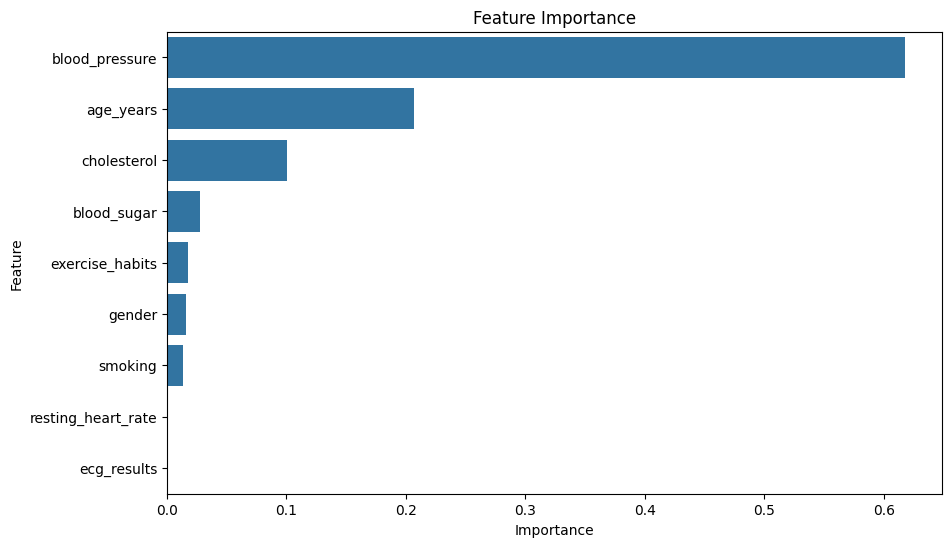


New Patient Prediction:
Heart Disease: Positive
Probability: 84.83%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (assumes cardio_train.csv is in working directory)
# If using a different path, adjust accordingly
df = pd.read_csv('/content/cardio_train.csv', sep=';')

# --- Preprocessing ---
# Drop unnecessary columns
df.drop('id', axis=1, inplace=True)

# Convert age from days to years
df['age_years'] = np.round(df['age'] / 365.25).astype(int)
df.drop('age', axis=1, inplace=True)

# Handle outliers and invalid values in blood pressure
# Remove rows where systolic < diastolic, or out of realistic ranges
df = df[(df['ap_hi'] > df['ap_lo']) &
        (df['ap_hi'].between(60, 250)) &
        (df['ap_lo'].between(30, 180))]

# Create average blood pressure feature
df['blood_pressure'] = (df['ap_hi'] + df['ap_lo']) / 2

# Drop original ap_hi and ap_lo
df.drop(['ap_hi', 'ap_lo'], axis=1, inplace=True)

# Filter unrealistic height and weight (optional, as not in original parameters)
df = df[df['height'].between(130, 200) &
        df['weight'].between(40, 150)]

# Drop height and weight to match original parameters
df.drop(['height', 'weight'], axis=1, inplace=True)

# Map gender: 1 -> 0 (female), 2 -> 1 (male)
df['gender'] = df['gender'].map({1: 0, 2: 1})

# Rename/map to match parameters
df.rename(columns={
    'gluc': 'blood_sugar',      # 1=normal, 2=above, 3=well above
    'smoke': 'smoking',        # 0=no, 1=yes
    'active': 'exercise_habits' # 0=no, 1=yes
}, inplace=True)

# Drop 'alco' as not in original parameters
df.drop('alco', axis=1, inplace=True)

# Add placeholders for missing features
df['resting_heart_rate'] = 70  # Average placeholder (no data available)
df['ecg_results'] = 0         # Normal placeholder (0=normal, assume)

# Handle missing values
df.dropna(inplace=True)

# Define features and target
features = ['age_years', 'gender', 'blood_pressure', 'cholesterol',
            'resting_heart_rate', 'blood_sugar', 'ecg_results',
            'smoking', 'exercise_habits']
X = df[features]
y = df['cardio']

# --- Data Visualization ---
print("\n--- Data Visualization ---")

# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df)
plt.title('Distribution of Heart Disease (Target)')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['age_years'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.show()

# Blood pressure distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['blood_pressure'], kde=True, bins=20)
plt.title('Distribution of Blood Pressure')
plt.xlabel('Blood Pressure (Average)')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap (including target)
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplot for blood pressure by target
plt.figure(figsize=(8, 5))
sns.boxplot(x='cardio', y='blood_pressure', data=df)
plt.title('Blood Pressure by Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Blood Pressure')
plt.show()

# --- Data Split: 20% train, 80% test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Model Training ---
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# --- Evaluation ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"\nModel Accuracy: {accuracy:.2%} on test dataset (80% of data)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# --- Prediction Function ---
def predict_new_patient(model, scaler, features, patient_data):
    # Convert patient data to DataFrame with correct feature order
    patient_df = pd.DataFrame([patient_data], columns=features)
    patient_scaled = scaler.transform(patient_df)
    prediction = model.predict(patient_scaled)
    probability = model.predict_proba(patient_scaled)[0][1]

    return {
        'prediction': 'Positive' if prediction[0] == 1 else 'Negative',
        'probability': probability
    }

if __name__ == "__main__":
    # Example prediction for a new patient
    new_patient = {
        'age_years': 55,
        'gender': 1,  # Male
        'blood_pressure': 140,  # Average BP
        'cholesterol': 2,  # Above normal
        'resting_heart_rate': 70,  # Placeholder
        'blood_sugar': 1,  # Normal
        'ecg_results': 0,  # Placeholder
        'smoking': 1,  # Yes
        'exercise_habits': 0  # No
    }

    prediction = predict_new_patient(rf_model, scaler, features, new_patient)
    print("\nNew Patient Prediction:")
    print(f"Heart Disease: {prediction['prediction']}")
    print(f"Probability: {prediction['probability']:.2%}")